# Processing precipitation data for PISM paleo simulations
The goal of this script is to take the RACMO reference data and temperature forcing data from http://www.pik-potsdam.de/~albrecht/pism_paleo_climate/, and combining it with ice elevation data and precipitation forcing factor from PISM results from https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml to get a 7D xarray that lines up with the snapshots1ka from the paleo PISM runs. The 7 dimensions are 125 time steps, a 361x361 spatial grid, and 4x4x4x4 forcing factors (but only one of them impacts precipitation forcing). 

In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


Display Precipitation reference

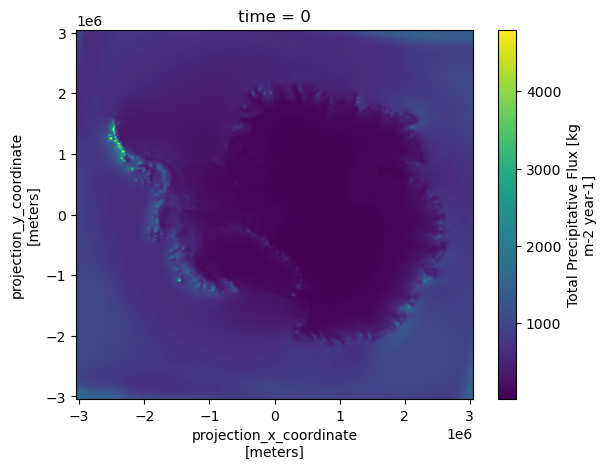

In [2]:
ds_surface_ref = xr.open_dataset('racmo_wessem_mean-d1.nc')
ds_ref = ds_surface_ref.assign_coords(time=[0])
precip_ref = ds_ref.precipitation
precip_ref.plot()

Open temperature forcing

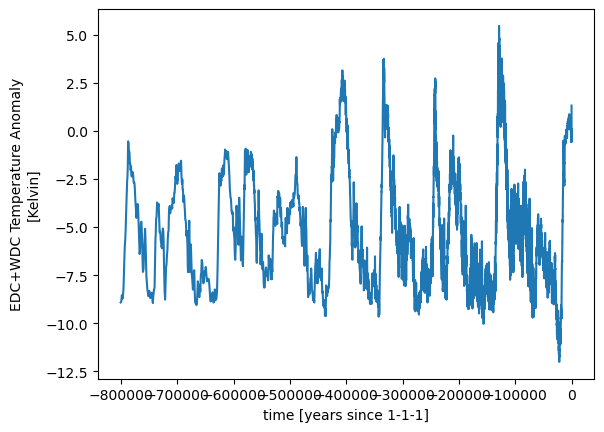

In [3]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)
ds_forcing.delta_T.plot()

In [4]:
# Loading in reference height
ref_h_ds = xr.open_dataset('bedmap2_16km-d1.nc',decode_times=False)
expanded_ds = ref_h_ds.expand_dims("time").assign_coords(time=("time", [0]))


In [5]:
ref_height = expanded_ds.drop_dims("nv4").usurf


Load PISM results

In [6]:
ref_height

<xarray.DataArray 'usurf' (time: 1, y: 381, x: 381)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) int64 0
Attributes:
    standard_name:  surface_altitude
    long_name:      ice upper surface elevation
    units:          meters
    grid_mapping:   mapping

In [7]:
# Made cluster and added in (address will vary)
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38145")
client

<Client: 'tcp://127.0.0.1:38145' processes=4 threads=8, memory=29.39 GiB>

In [8]:
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')
snapshots = cat["snapshots1ka"].to_dask()

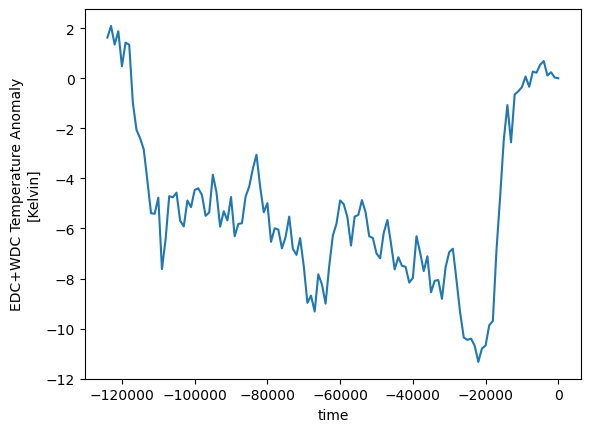

In [9]:
# Interpolate forcing onto same grid as snapshots
ds_forcing_interp = ds_forcing.interp(time=snapshots.time)
ds_forcing_interp.delta_T.plot()

Applying anomaly and expanding precipitation to be on the same grid as the velocities

In [10]:
# initial time
precip_evol = precip_ref * np.exp(snapshots.par_prec*ds_forcing_interp.delta_T.isel(time=0)) * np.exp(0.554*(snapshots.usurf.isel(time=0)-ref_height)/1000)
precip_evol = precip_evol.assign_coords(time=[snapshots.time[0]])

# iterate through each timestep
for i in range(1,len(snapshots.time)):
    precip_temp = precip_ref * np.exp(snapshots.par_prec*ds_forcing_interp.delta_T.isel(time=i)) * np.exp(0.554*(snapshots.usurf.isel(time=i)-ref_height)/1000)
    precip_temp = precip_temp.assign_coords(time=[snapshots.time[i]])
    precip_evol = xr.concat([precip_evol,precip_temp],dim='time')

In [11]:
# check resulting structure
precip_evol

,Array,Chunk
Bytes,34.61 GiB,70.88 MiB
Shape,"(125, 381, 381, 4, 4, 4, 4)","(1, 381, 381, 4, 1, 4, 4)"
Count,1375 Graph Layers,500 Chunks
Type,float64,numpy.ndarray


Looking at different mean precipitation forcing depending on precipitation setting

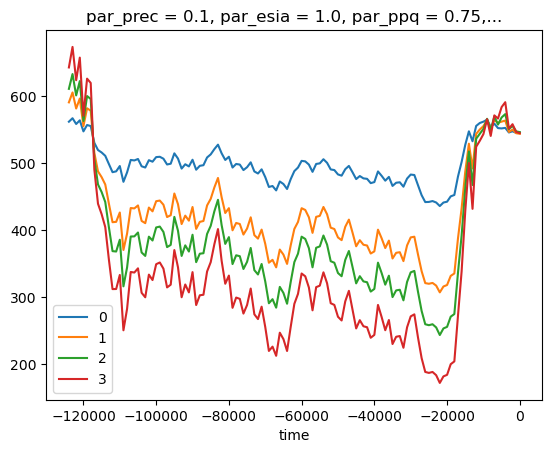

In [12]:
ax = plt.figure()
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 0,par_visc = 2).mean(dim=['x','y']).plot(label='0')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 1,par_visc = 2).mean(dim=['x','y']).plot(label='1')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 2,par_visc = 2).mean(dim=['x','y']).plot(label='2')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 3,par_visc = 2).mean(dim=['x','y']).plot(label='3')
plt.legend()

# Similar process to determine the temperature forcing at each grid point
Note that I added a negative sign in front of the latitudes as they were all negative and giving really high temperature values. The current values make a bit more sense

In [22]:
T_annual_mean_ref = 37.5 - (0.0095 * np.maximum(ref_height, 1000)) - (0.644 * -precip_evol.lat) + (2.145 * np.cos(np.deg2rad(precip_evol.lon + 110)))
T_annual_mean_ref = T_annual_mean_ref.assign_coords(time=[snapshots.time[124]])

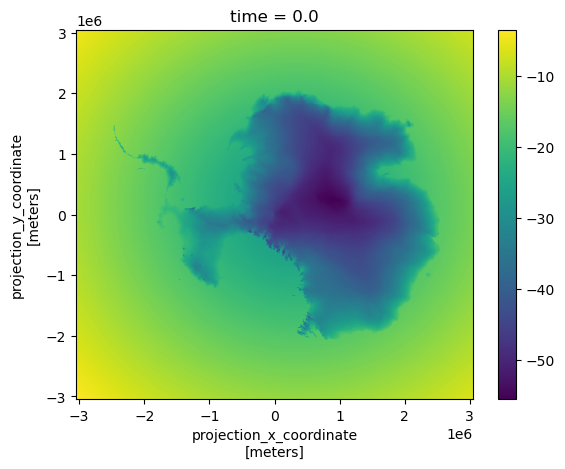

In [23]:
T_annual_mean_ref.plot()

In [39]:
# initial time
T_annual_mean_evol = T_annual_mean_ref + ds_forcing_interp.delta_T.isel(time=0) - (0.0095 * (np.maximum(ref_height, 1000)-np.maximum(snapshots.usurf.isel(time=0), 1000)))
T_annual_mean_evol = T_annual_mean_evol.assign_coords(time=[snapshots.time[0]])
# iterate through each timestep
for i in range(1,len(snapshots.time)):
    T_annual_mean_temp = T_annual_mean_ref + ds_forcing_interp.delta_T.isel(time=i) - (0.0095 * (np.maximum(ref_height, 1000)-np.maximum(snapshots.usurf.isel(time=i), 1000)))
    T_annual_mean_temp = T_annual_mean_temp.assign_coords(time=[snapshots.time[i]])
    T_annual_mean_evol = xr.concat([T_annual_mean_evol,T_annual_mean_temp],dim='time')

Looking at shape of data

In [40]:
T_annual_mean_evol

,Array,Chunk
Bytes,34.61 GiB,70.88 MiB
Shape,"(125, 381, 381, 4, 4, 4, 4)","(1, 381, 381, 1, 4, 4, 4)"
Count,1000 Graph Layers,500 Chunks
Type,float64,numpy.ndarray


Plotting evolution.

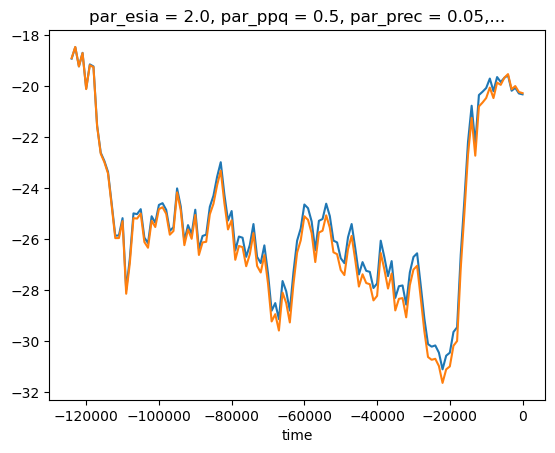

In [41]:
T_annual_mean_evol.isel(par_esia=0,par_ppq = 2, par_prec= 0,par_visc = 2).mean(dim=['x','y']).plot()
T_annual_mean_evol.isel(par_esia=1,par_ppq = 1, par_prec= 1,par_visc = 1).mean(dim=['x','y']).plot()

Now, we have a precipitation forcing `precip_evol` and a temperature forcing `T_annual_mean_evol` at each gridpoint for each ensemble at each time step. These will be reshaped in the same way the velocity results are reshaped and used as inputs for a to-be-determined ML model. 

An interesting thing to note is that since we're sort of "inverting" for the precipitation and temperature values using the calculated surface height results, what I believe should be the same forcing at every time step (at least for temperature) is slightly different between ensembles. I believe this is because the heights are different so over time the surface temperature forcing values will diverge. 

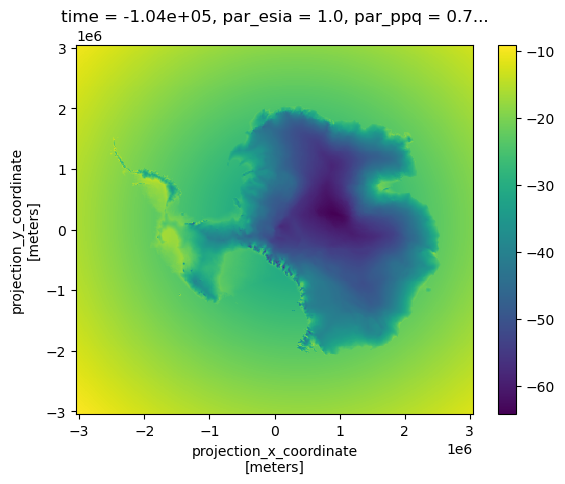

In [48]:
T_annual_mean_evol.isel(par_esia=0,par_ppq = 2, par_prec= 0,par_visc = 2,time = 20).plot()

I am a bit concerned about the discerepency between our determined temperatures and the reference temperature (shown below). I'm assuming this is due to differences in the bedmap2 reference height and the calculated height from PISM

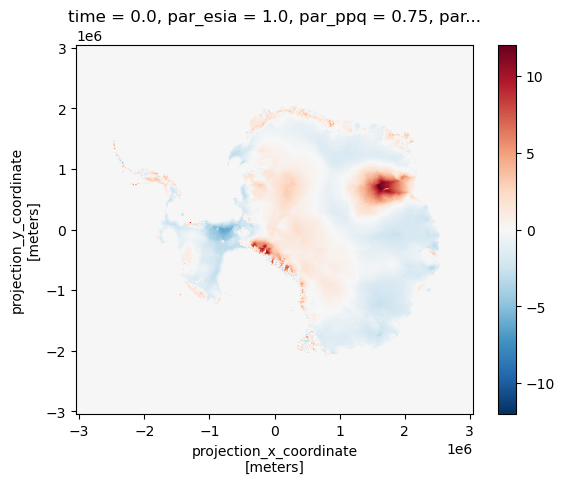

In [49]:
(T_annual_mean_evol.isel(par_esia=0,par_ppq = 2, par_prec= 0,par_visc = 2,time = 124)-T_annual_mean_ref).plot()